# Orbitrap-data-sort-bracketing

Version 1.0 (22/1/23)

A script to process cleaned Orbitrap scan data and remove outling injections

### Inputs: 
- The path to a series of 'additional_output' files from Thermo R script (v3) which contain cleaned Orbitrap data for every scan in a run
- AGC and microscan settings
- Name of internal standard, matching that used in sequence
- Name of isotope reference data  
### Additional inputs for no-M0 experiments:
- Path to internal deltas for M0 experiment for same samples
- Identity of basepeak

### Outputs: 
- For each injection, a 'injection_sorted' file  which contain the for each scan, the sample name, timestamp, TIC, ion count and ratio for each isotopologue measured
- One summary '_summary' file containing, for each injection: mean isotopologue ratios, plateau start/stop times (min), scan count, mean TIC (/s), mean ion injection time (ms), and median scan duration (ms)
- Internal deltas 'internal_deltas_YYYY-MM-DD.csv' and summary 'internal_deltas_summary_YYYY-MM-DD.csv' , relative to the internal standard used
- External (uncalibrated) deltas 'external_deltas_YYYY-MM-DD.csv' and summary 'external_deltas_summary_YYYY-MM-DD.csv', calculated using the known values of the internal standard

### Import packages and specify input parameters

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# inputs
path = '240222_std_test_1_noM0/'
outputpath = 'data_sorted/'

ref_filename = 'references_nitrate.xlsx'
internal_std = 'USGS35-IS'

AGC = 0.3
microscan_dur_sec = 36e-3

# inputs for no-m0 data
noM0input = '240222_std_test_1_M0/internal_deltas_2024-02-22.csv'
basepeak='15N'



datafiles = [string for string in os.listdir(path)  if string.split('_')[0]=='Additional' ] 
if len(datafiles)==1:
    inputpath = datafiles[0]
    print('Found data file at ' + path+inputpath)
else:
    inputpath = datafiles[0]
    print('Found multiple data files. Using ' + path+inputpath)
    


Found data file at 240222_std_test_1_noM0/Additional_Output_2024-02-22.csv


## 1. Read and sort additional_output files
Saves '_sorted.csv' files for each injection and one summary '_summary.csv' file in the outputpath folder

In [2]:
# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder(path, outputpath)


# Read the CSV file into a DataFrame
data = pd.read_csv(os.path.join(path,inputpath))

# add zero to filename suffixes
def change_suffix(s):
    parts = s.split('_')
    if len(parts) > 1:
        if len(parts[-1])<2:
            s = s[0:-2]+'_0'+parts[-1]
    return s

# Sorting by filename suffix
data['filename'] = data['filename'].apply(change_suffix)
data = data.sort_values(by='filename')

# Extract filenames
filenames = data['filename'].unique()

# DataFrame for metadata
summ=pd.DataFrame(columns=['sample_name','filename','experiment','start_t_min','stop_t_min','scans','TIC_av','injection_t_ms','scan_dur_ms'],index=range(len(filenames)))

# Loop through files
for i,fn in enumerate(filenames):

    # Take one injection only
    df = data[data['filename'] == fn]
    df = df.sort_values(by='time.min')

# nitrate M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='M0 is base peak':

        experiment = 'NO3_M0'
        # separate isotopologues into their own DataFrame
        M0_df = df[df['isotopolog'] == 'M0'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_M0'})
        N15_df = df[df['isotopolog'] == '15N'][['time.min','Ratio']]
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(M0_df,N15_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N'})
        ratio_df = pd.merge(ratio_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})

# nitrate no-M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='15N is base peak':

        experiment = 'NO3_noM0'
        # separate isotopologues into their own DataFrame
        N15_df = df[df['isotopolog'] == '15N'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_15N'})
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        N15O18_df = df[df['isotopolog'] == '15N18O'][['time.min','Ratio']]
        O17O18_df = df[df['isotopolog'] == '17O18O'][['time.min','Ratio']]
        O18O18_df = df[df['isotopolog'] == '18O18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(N15_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})
        ratio_df = pd.merge(ratio_df,N15O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N18O'})
        ratio_df = pd.merge(ratio_df,O17O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O18O'})
        ratio_df = pd.merge(ratio_df,O18O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O18O'})

    # sort by time.min column, add experiment column
    ratio_df = ratio_df.sort_values(by='time.min')
    ratio_df.insert(1,'experiment',[experiment]*len(ratio_df))
    # save output to .csv
    ratio_df.to_csv(os.path.join(path, outputpath, fn+'_sorted_'+df['sample.name'].iloc[0]+'.csv'))
    
    mean_ratios = ratio_df[ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]].mean()
    for col,val in mean_ratios.iloc[::-1].items():
        if col in summ.columns:
            summ.at[i,col] = val
        else:
            summ.insert(1,col,[np.nan]*len(summ))
            summ.at[i,col] = val
    
    summ.loc[i,'sample_name']=df['sample.name'].iloc[0]
    summ.loc[i,'filename']=''.join([fn, '_sorted_',df['sample.name'].iloc[0],'.csv'])
    summ.loc[i,'scans']=len(df[df['isotopolog']==df['isotopolog'].iloc[0]])
    summ.loc[i,'start_t_min']=df['time.min'].min()
    summ.loc[i,'stop_t_min']=df['time.min'].max()
    summ.loc[i,'TIC_av']=df['tic'].mean()
    summ.loc[i,'injection_t_ms']=df['it.ms'].mean()
    summ.loc[i,'scan_dur_ms']=np.median(np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[1:])-np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[:-1]))*60000
    summ.loc[i,'experiment']=experiment
    
# export metadata as csv
summ.to_csv(os.path.join(path, outputpath,fn.split('_')[0]+'_summary_nonfiltered.csv'))

print('Saved '+ str(len(filenames)) + ' sorted data files from ' + filenames[0] + ' to ' + filenames[-1] + '.')
print('Saved summary file as ' + os.path.join(path, outputpath,fn.split('_')[0]+'_summary_nonfiltered.csv.'))

Folder 'data_sorted/' already exists at '240222_std_test_1_noM0/'.
Saved 25 sorted data files from 240221_01 to 240221_25.
Saved summary file as 240222_std_test_1_noM0/data_sorted/240221_summary_nonfiltered.csv.


/Users/jacksaville/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jacksaville/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## 2. Check for mistakes and outlying injections


### Plot average TICs and isotopologue ratios over sequence - check for empty vials and outliers

$ TIC > 10^6 \times AGC \times \frac{n_{\mu scans}}{t_{scan}} $ is required

TIC must exceed 8.33e+06 ions/s


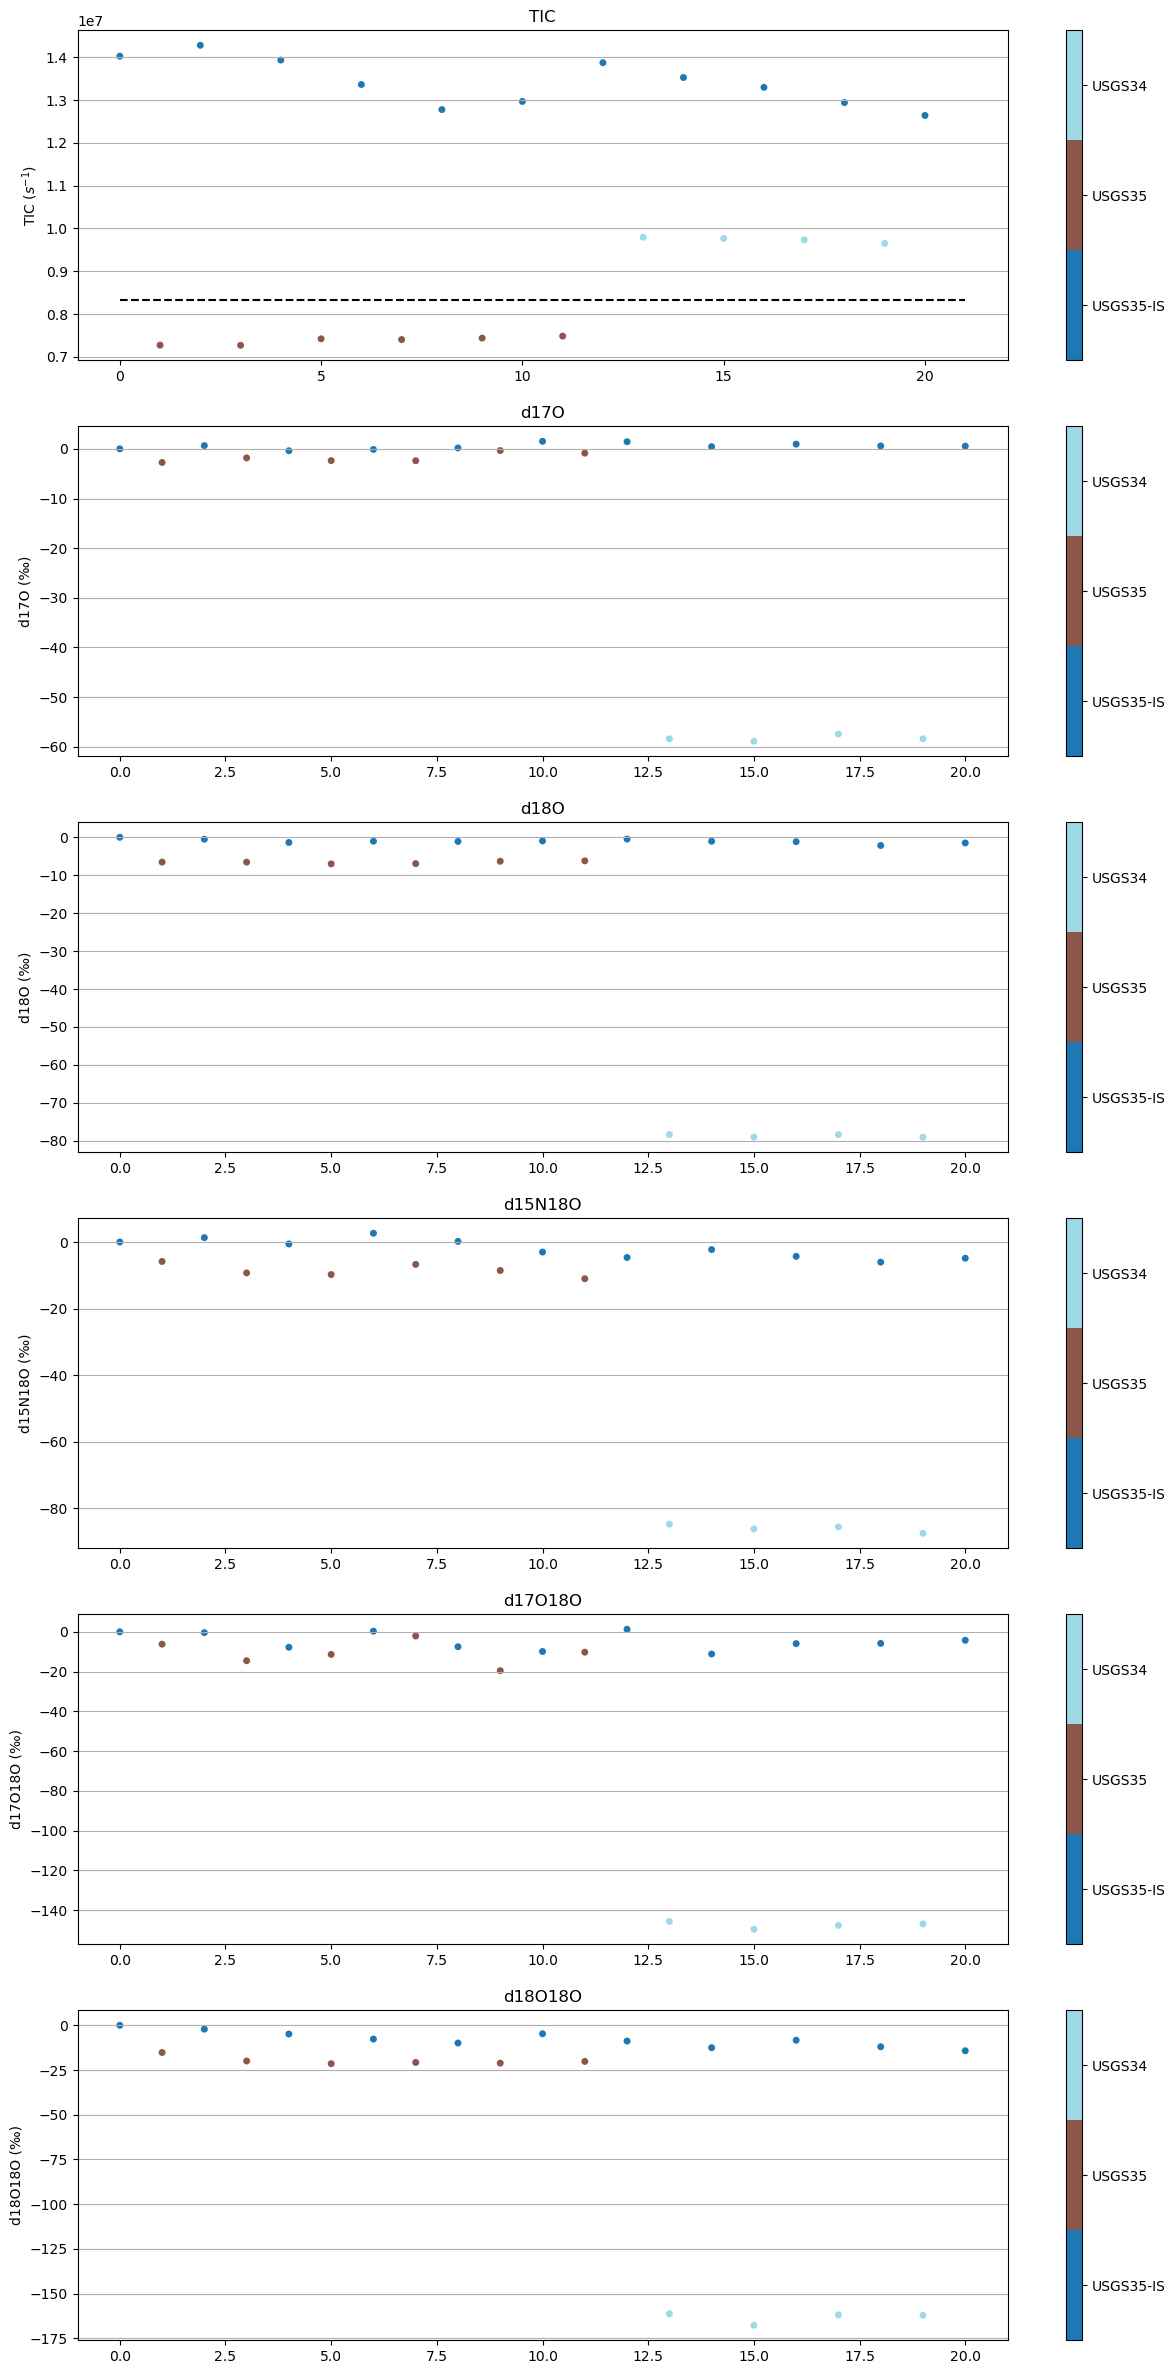

In [3]:
# calculate limit TIC
lim_TIC = 1e6*AGC/microscan_dur_sec
print('TIC must exceed '+f"{lim_TIC:.3g}"+ ' ions/s')

summ = pd.read_csv(os.path.join(path, outputpath, [string for string in os.listdir(os.path.join(path,outputpath)) if string.split('_')[-2]=='summary' ][0]))

filenames = summ['filename']
rcols = ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]

fig,ax = plt.subplots(1+len(rcols), figsize=[15,5*(1+len(rcols))])

categories = summ['sample_name']

from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)

category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

# TIC plot
scatter = ax[0].scatter(summ.index, summ['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
cbar.set_ticklabels(categories.unique())
ax[0].plot([0,len(summ)],[lim_TIC,lim_TIC], '--',c='k')
# ax[0].set_yscale('log')
ax[0].grid(True, axis='y')
ax[0].set_ylabel('TIC ($s^{-1}$)')
ax[0].set_title('TIC')

# isotopologue ratio plots
for i,col in enumerate(rcols):
    j=i+1
    scatter = ax[j].scatter(summ.index, (summ[col]/summ.loc[0,col]-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.', s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax[j].grid(True, axis='y')
    ax[j].set_ylabel('d' + col.split('_')[-1] + ' (‰)')
    ax[j].set_title('d' + col.split('_')[-1])



### Plot TIC and $\delta^{18}O$ curves for each sample
Set plots = True to see plots  

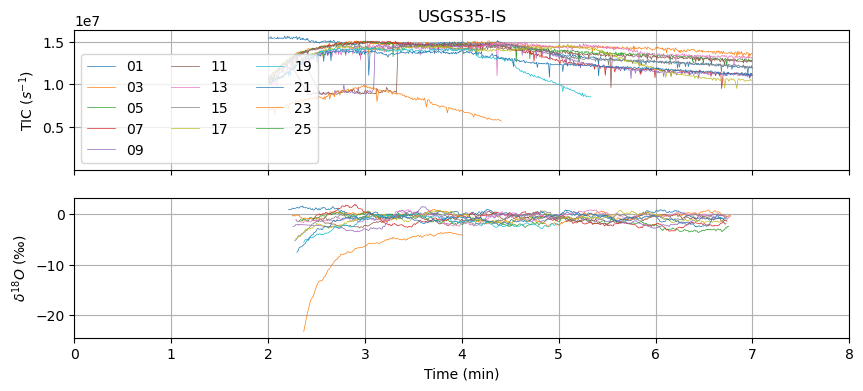

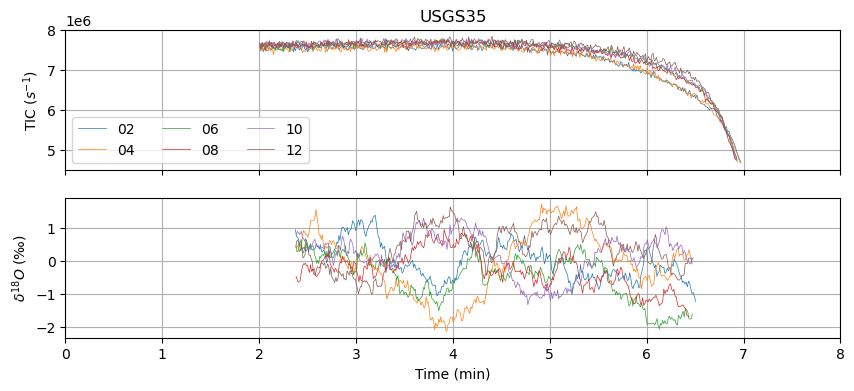

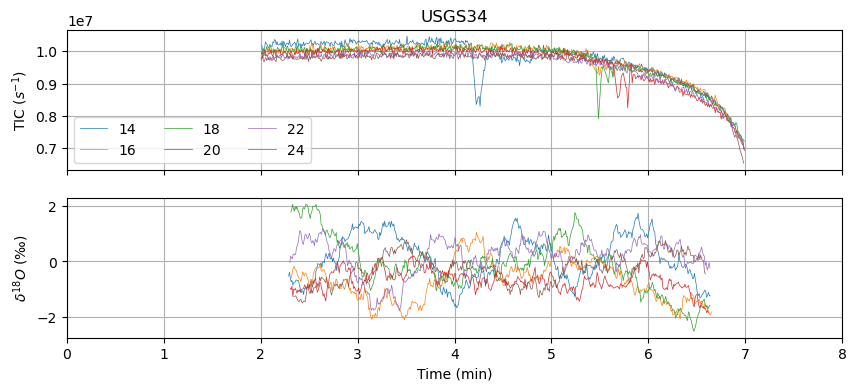

In [46]:
plots = True

# load metadata.csv
summ = pd.read_csv(os.path.join(path,outputpath,[s for s in os.listdir(os.path.join(path,outputpath)) if s.endswith('_summary_nonfiltered.csv')][0]))

sample_names = np.array([x for x in summ['sample_name'].unique()])

for i, sample in enumerate(sample_names):
    if plots == True:
        fig,ax = plt.subplots(2, figsize = [10,4])
        samplefilenames = summ[summ['sample_name']==sample]['filename']

            
        ref_18O = pd.read_csv(os.path.join(path,outputpath,samplefilenames.iloc[0]))['Ratio_18O'].mean()
        
        for j, sam in enumerate(samplefilenames):

            data = pd.read_csv(os.path.join(path,outputpath,sam))
            scandur = 0.003
            meandur = 0.2
            window_size = int(meandur / scandur)
            data[['Rolling_18O']] = data[['Ratio_18O']].rolling(window=window_size, center=True).mean()

            ax[0].set_title(data['sample.name'].iloc[0])

            ax[0].plot(data['time.min'],data['tic'], label=sam.split('_')[1], lw=0.5)
            ax[0].set_xlim([0, 8])
            ax[0].grid(True,axis='both')
            ax[0].set_ylabel('TIC ($s^{-1}$)')
            ax[0].legend(ncols=3)        
            ax[0].set_xticklabels([])


            ax[1].plot(data['time.min'],1000*(data['Rolling_18O']/ref_18O-1), lw=0.5)
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].grid(True,axis='both')
            ax[1].set_ylabel('$\delta^{18}O$ (‰)')

            ax[-1].set_xlabel('Time (min)')

### Injection filtering
Remove unfaithful injections using filters or by hand 

In [39]:
print('List of the first occurence of each sample name')
summ['sample_name'].drop_duplicates()

List of the first occurence of each sample name


0     USGS35-IS
4        USGS35
16       USGS34
Name: sample_name, dtype: object

In [51]:
summ_filt = summ.copy()

# Remove all injections after a given one 
if True:
    removefrom = 21     # specify start of set to be removed here
    toremove = summ_filt.iloc[removefrom:]
    print('Removed '+str(len(toremove)) + ' injections after #'+str(removefrom)+': \n'+ str(list(toremove.index)))
    summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# blank filter
toremove = summ_filt[summ_filt['sample_name'].str.startswith('Blank')]
print('Removed '+str(len(toremove)) + ' blank injections: \n'+ str(list(toremove.index)))
summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# minimum TIC filter
if False:
    toremove = summ_filt[summ_filt['TIC_av']<lim_TIC]
    print('Removed '+str(len(toremove)) + ' further injections with TIC<'+f'{lim_TIC:.3g}: \n'+ str(list(toremove.index)))
    summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# Other injection numbers to remove manually
remove = []
toremove = summ_filt.iloc[remove]
print('Removed '+str(len(toremove)) + ' addional injections: \n'+ str(list(toremove.index)))
summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# Display remaining injection numbers
print(str(len(summ_filt))+' injections remain: \n' +str(list(summ_filt.index)))

Removed 4 injections after #21: 
[21, 22, 23, 24]
Removed 0 blank injections: 
[]
Removed 0 addional injections: 
[]
21 injections remain: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [52]:
# export filtered summary file as csv
summ_filt.to_csv(sep.join([path, outputpath,fn.split('_')[0],'_summary_filtered.csv']))
print('Saved summary file as ' + sep.join([path, outputpath,fn.split('_')[0],'_summary_filtered.csv.']))

Saved summary file as 240222_std_test_1_noM0/data_sorted/240221_summary_filtered.csv.


## 3. Bracketing
Uses brackting formula: $\delta = \frac{2R_i}{R_{i-1}+R_{i+1}}-1$ to calculate internal deltas for each isotopologue for every sample which is surrounded by internal standards.  
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.  
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.

Bracketed internal delta values relative to basepeak saved as 240222_std_test_1_noM0/internal_deltas_2024-02-22.csv
Summarised ouptut saved as 240222_std_test_1_noM0/internal_deltas_summary_2024-02-22.csv


,sample_name,mean_17O,mean_18O,mean_15N18O,mean_17O18O,mean_18O18O,err_17O,err_18O,err_15N18O,err_17O18O,err_18O18O
0,USGS34,-0.058977,-0.077495,-0.082065,-0.142268,-0.153888,0.000305,0.000245,0.000515,0.000279,0.001757
1,USGS35,-0.002187,-0.005731,-0.008238,-0.006597,-0.014243,0.000252,0.000142,0.000675,0.001839,0.000618


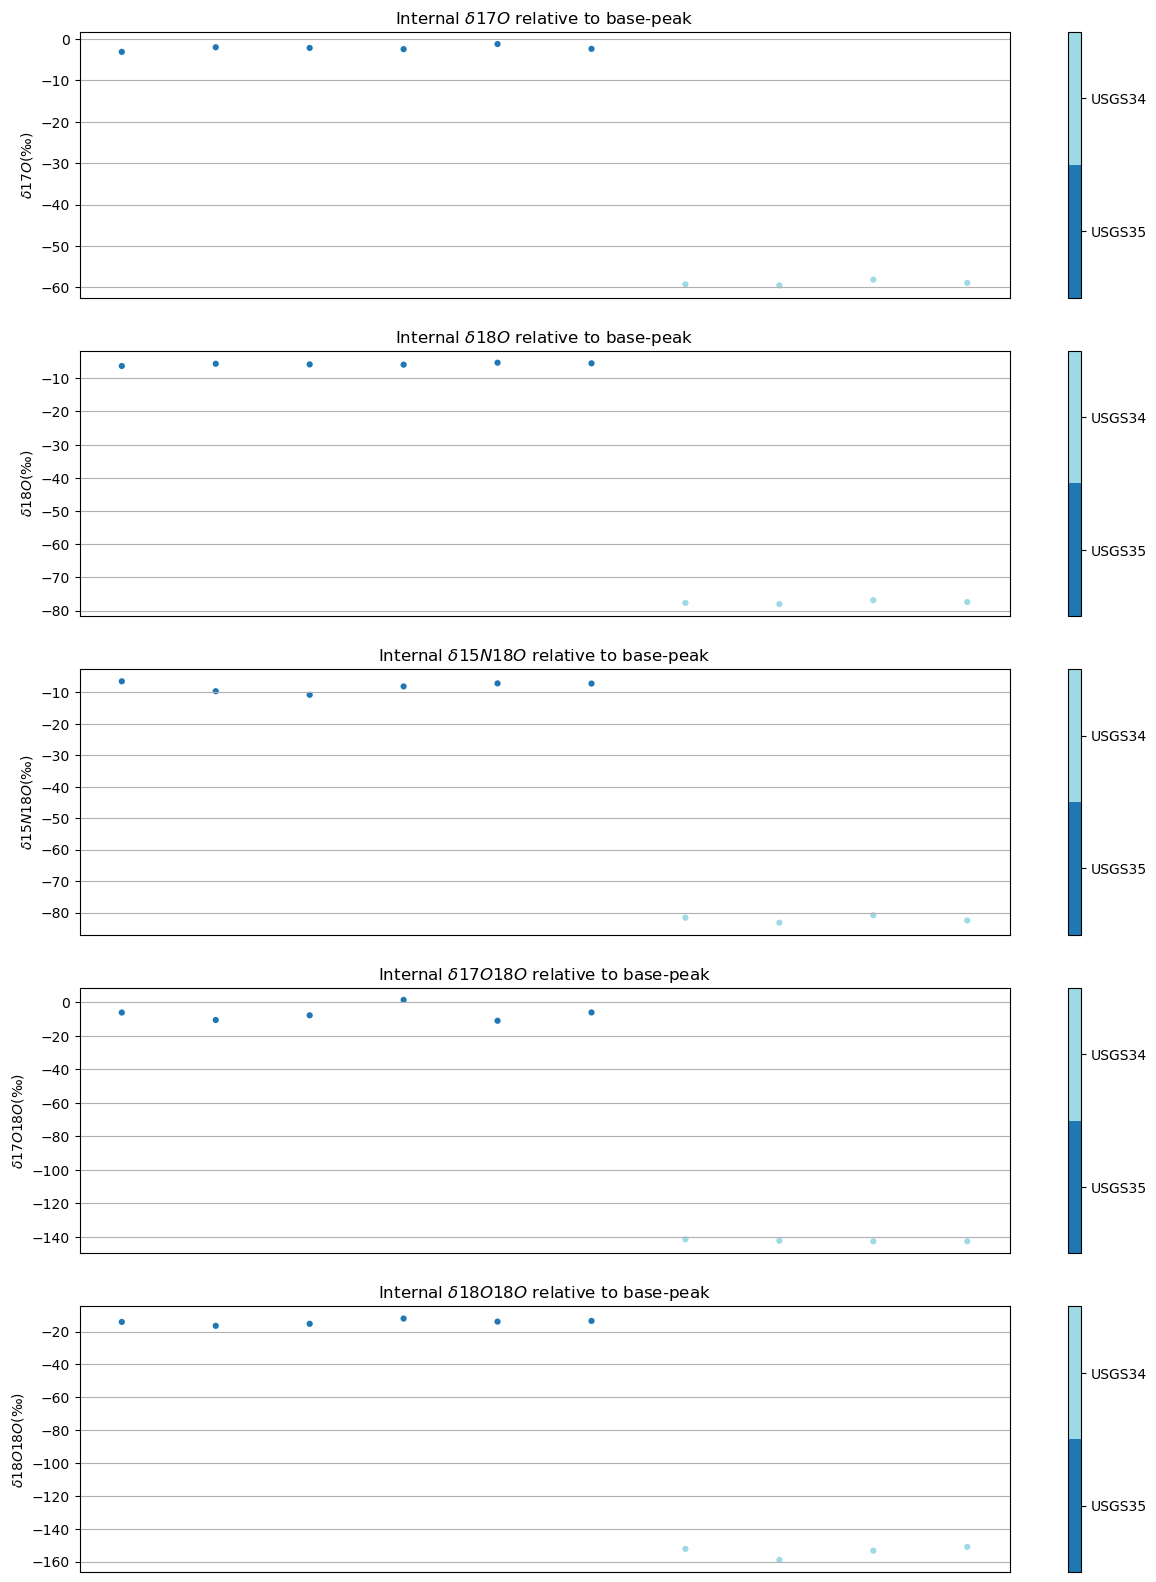

In [7]:
# identify isotopologs
isotopologues = [col.split('_')[1] for col in summ.columns if col.split('_')[0]=='Ratio']
    
# identify sample injections
samples = summ[summ['sample_name'] != internal_std]
samples_delta = pd.DataFrame(columns=['sample_name','experiment']+['d'+iso for iso in isotopologues]+['rel_to'],index = samples.index)
samples_delta.loc[:,'sample_name']=samples.loc[:,'sample_name']
samples_delta.loc[:,'experiment']=samples.loc[:,'experiment']

# bracketing
for i in samples.index:
    if i-1 in summ.index and i+1 in summ.index:
        if summ.loc[i-1,'sample_name']==internal_std and summ.loc[i+1,'sample_name']==internal_std:
            R_i = summ.loc[i,['Ratio_'+iso for iso in isotopologues]]
            R_minus = summ.loc[i-1,['Ratio_'+iso for iso in isotopologues]]
            R_plus = summ.loc[i+1,['Ratio_'+iso for iso in isotopologues]]
            deltas = 2*R_i/(R_minus+R_plus)-1
            samples_delta.loc[i,['d'+iso for iso in isotopologues]] =deltas.tolist()

    samples_delta.loc[i,'rel_to'] = internal_std
samples_delta.dropna(how='all',subset=['d'+iso for iso in isotopologues],inplace=True)

# save
samples_delta.to_csv(os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))
print('Bracketed internal delta values relative to basepeak saved as '+ os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))

# summarise internal deltas per sample
stats=pd.DataFrame()
stats['sample_name']=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats[['mean_'+iso for iso in isotopologues]]=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
stats[['err_'+iso for iso in isotopologues]]=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]

    # plot
if True:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = samples_delta['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(samples_delta.index, samples_delta['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories)) + 1) - 0.5)
        cbar.set_ticklabels(categories.unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to base-peak')
        ax[i].set_xticks([])

        
# save
stats.to_csv(os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))

# display
stats.head(20)

## 4. Change of reference of M1-based deltas to M0 (if applicable)
Uses change of reference formula: $\delta_{M2/M0} = \delta_{M2/M1} + \delta_{M1/M0} + \delta_{M2/M1}\times\delta_{M1/M0}$ and Orbitrap internal deltas of corresponding M0 sequence found at the path input at the top of script.  
This will only change deltas relative to the no-M0 basepeak (input at top of script).

Previously saved files are overwritten:
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


In [52]:
df = pd.read_csv(noM0input)

dM1=pd.DataFrame()
dM1['sample_name']=df.groupby('sample_name')['d'+basepeak].mean().reset_index()['sample_name']
dM1['mean_d'+basepeak]=df.groupby('sample_name')['d'+basepeak].mean().reset_index()['d'+basepeak]
dM1['sem_d'+basepeak]=df.groupby('sample_name')['d'+basepeak].sem().reset_index()['d'+basepeak]

print('Found the following delta M1/M0 values at '+noM0input)
dM1

Found the following delta M1/M0 values at 240222_std_test_1_M0/internal_deltas_2024-02-22.csv


,sample_name,mean_d15N,sem_d15N
0,USGS34,-0.006042,0.000513
1,USGS35,-0.001228,0.000554


In [53]:
delta_changed = samples_delta.copy()
for i in samples_delta.index:
    if samples_delta.loc[i,'experiment'].split('_')[-1]=='noM0':
        if samples_delta.loc[i,'sample_name'] in dM1['sample_name'].values:
            index_in_dM1 = dM1[dM1['sample_name'] == samples_delta.loc[i,'sample_name']].index[0]
            
            d1 = dM1.loc[index_in_dM1,'mean_d'+basepeak]
            d2 = samples_delta.loc[i, ['d'+iso for iso in isotopologues]]
            
            delta_changed.loc[i,['d'+iso for iso in isotopologues]] = d1+d2+d1*d2

delta_changed.to_csv(os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))
print('Changed reference of no-M0 sample delta values to M0. Output saved as '+os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))

# summarise m0-based internal deltas per sample
stats_changed=pd.DataFrame()
stats_changed['sample_name']=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats_changed[['mean_'+iso for iso in isotopologues]]=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
stats_changed[['err_'+iso for iso in isotopologues]]=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]

# plot
if False:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = delta_changed['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(delta_changed.index, delta_changed['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() + 1)) + 0.5)
        cbar.set_ticklabels(pd.Series(categories).unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to $M_0$')
        ax[i].set_xticks([])

# save
stats_changed.to_csv(os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))

# display
stats_changed.head(20)

Changed reference of no-M0 sample delta values to M0. Output saved as 240222_std_test_1_M0/internal_deltas_2024-02-22.csv
Summarised ouptut saved as 240222_std_test_1_M0/internal_deltas_summary_2024-02-22.csv


,sample_name,mean_15N,mean_17O,mean_18O,err_15N,err_17O,err_18O
0,USGS34,-0.006042,-0.065959,-0.083334,0.000513,0.000922,0.000447
1,USGS35,-0.001228,-0.001651,-0.005852,0.000554,0.000754,0.000391


## 5. Conversion of internal deltas to international scale based on values of internal standard
Reference delta values of internal standard are taken from the reference data (inputs at top of script).  

Saves external deltas:
- Saves external deltas as 'external_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'external_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


Imported reference data for internal standard USGS35 from references_nitrate.xlsx
   mean_d15N  mean_d17O  mean_d18O
1     0.0027     0.0515     0.0575
Changed reference of internal deltas to international reference scale. Output saved as 240222_std_test_1_M0/external_deltas_2024-02-22.csv
Summarised ouptut saved as 240222_std_test_1_M0/external_deltas__summary2024-02-22.csv


,sample_name,mean_15N,mean_17O,mean_18O,err_15N,err_17O,err_18O
0,USGS34,-0.003358,-0.017856,-0.030626,0.000514,0.000969,0.000473
1,USGS35,0.001469,0.049764,0.051311,0.000556,0.000792,0.000413


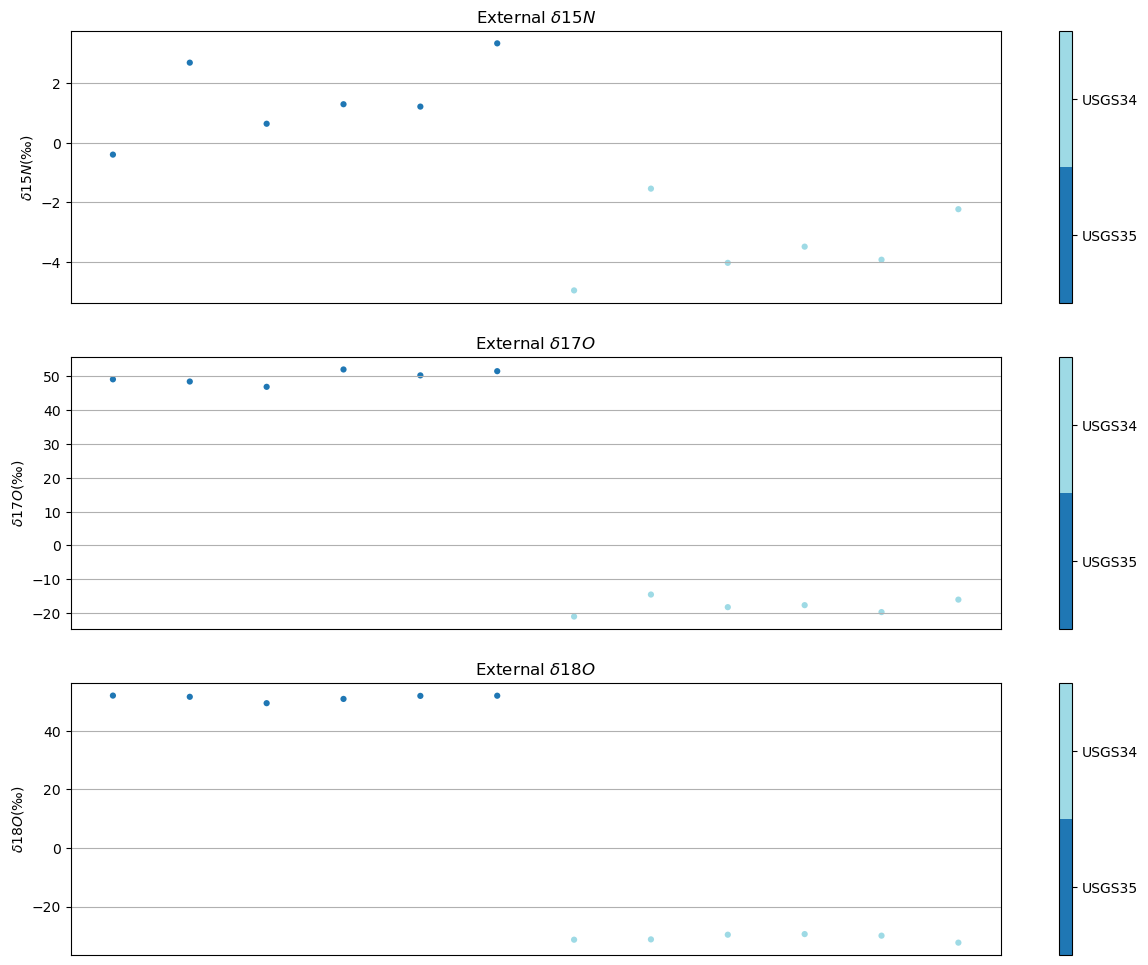

In [54]:
df = delta_changed.copy()

# Import reference data for internal standard
references = pd.read_excel(ref_filename)

internal_std_short = internal_std.split('-')[0]
refs_stats = references[references['sample_name']==internal_std_short]
refs_stats.loc[:,refs_stats.columns[1:]] = refs_stats.loc[:,refs_stats.columns[1:]]*1e-3

# display
print('Imported reference data for internal standard '+internal_std_short+' from '+ ref_filename)
print(refs_stats[['mean_d'+ iso for iso in isotopologues if 'mean_d'+ iso in refs_stats.columns]])

# identify isotopologues
isotopologs = [iso for iso in df.columns if iso.startswith('d')]

# change reference to international scale based on internal standard supposed values
df_international_scale=df.copy()
for i in df.index:
    # identify and rename the internal standard used
    int_std_name = df.loc[i,'rel_to']
    int_std_name = int_std_name.split('-')[0]
    # select internal standard delta vals
    if int_std_name in list(refs_stats['sample_name']):
        int_std_cols = ['mean_'+iso for iso in isotopologs  if 'mean_'+iso in refs_stats.columns if len(iso)==4 ]
        int_std_deltas = refs_stats[refs_stats['sample_name']==int_std_name][int_std_cols]
         # correct using change of reference formula
        for col in int_std_deltas.columns:
            d1 = df.loc[i, col.split('_')[-1]] # internal delta for all samples
            d2 = int_std_deltas[col].iloc[0]  #delta of standard
            d_corr = d1 + d2 + d1*d2
            df_international_scale.loc[i, col.split('_')[-1]] = d_corr
        df_international_scale.loc[i,'rel_to'] = 'international reference'
    else:
        print("Couldn't find standard: "+ int_std_name+ ' in reference data. Using internal deltas for '+ str(df.loc[i,'sample_name']))

# save deltas as csv
df_international_scale.to_csv(os.path.join(path,'external_deltas_'+current_date_string+'.csv'))
print('Changed reference of internal deltas to international reference scale. Output saved as '+os.path.join(path,'external_deltas_'+current_date_string+'.csv'))

# plot
fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

categories = df_international_scale['sample_name']
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

for i,iso in enumerate(isotopologues):
    scatter = ax[i].scatter(df_international_scale.index, df_international_scale['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
    cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() )+ 1) - 0.5)
    cbar.set_ticklabels(pd.Series(categories).unique())
    ax[i].grid(True, axis='y')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('External $\delta' + iso +'$')
    ax[i].set_xticks([])
    
# summary
stats=pd.DataFrame()
stats['sample_name']=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats[['mean_'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
stats[['err_'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# save
stats.to_csv(os.path.join(path,'external_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'external_deltas__summary'+current_date_string+'.csv'))
# display
stats